# Imports

In [1]:
# general
import os
import sys
from os import path
from collections import Counter
from itertools import product
from joblib import dump, load

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix

# XGBoost
import xgboost as xgb

# NLP
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import fasttext

# Custom
from cf_matrix import *
from data_io import *
from utils import *

In [2]:
# uncomment and run if stopword package not installed yet
# nltk.download('stopwords')
# from spacy.cli import download
# download('en')

In [2]:
%load_ext autoreload
%autoreload 2

# Fasttext unsupervised learning

Data to be loaded is required to be in subfolder "/data"

In [ ]:
# create folder to store and load models
if os.path.isdir('./models'):
    print("Models folder exists.")
else:
    print("Models folder does not exist and is created.")
    os.mkdir('./models')

## Preprocessing

To use fasttext, we first create a txt-file with preprocessed sentences. We also create preprocessed lists of sentences for the mean embeddings afterwards.

Preprocessing consists of:
- Clean end-of-line characters
- Lowercase
- Tokenize
- Stopwords removal
- Digit replacement

In [4]:
# created preprocessed txt-file to use for fasttext unsupervised algorithm
# txt-file is stored in ./data folder
preprocess_fasttext(mode='train', labels=False, normalized=True)

In [5]:
# create preprocessed list for mean embedding
texts_train_norm, y_train  = get_normalized_data('train')
texts_val_norm, y_val  = get_normalized_data('val')
texts_test_norm, y_test  = get_normalized_data('test')

## grid search

In the following we will perform grid search to find an appropriate parametrization of the fasttext model. 
Performance will be measured by F1-score after a logistic classifier was trained on the corresponding embeddings. A logistic classifier was selected as could be trained within a reasonable amount of time. To limit training time, we also only use 3 epochs. Later we checked that more epochs, e.g. 5 or 10, only had a neglible effect and therefore could be discarded.

Besides the subsequent one, various parameter sets were tried. Note that running the following grid search takes several hours and is not recommended to perform. 

To reproduce the results, it thus recommended to uncomment the single parametrization of the model that was used in the end in order to perform only one run. Alternatively, the stored model can be provided upon request as it quite large (>1GB).

In [9]:
# set new parameters for grid search
MOD_TYPES = ['cbow','skipgram']  # model type
DIMS = [50, 100, 200, 250]       # size of word vectors [100]
EPOCHS = [3]                     # number of epochs [5]
NGRAMS = [1, 2]                  # max length of word ngram [1]
LRS = [0.05]                     # learning rate [0.05]
MIN_COUNTS = [1, 5]              # minimal number of word occurences [1]
CONTEXT_WS = [5]                 # size of the context window [5]
NEGS = [5]                       # number of negatives sampled [5]

# Uncomment to run "grid search" only with the final parametrization

# MOD_TYPES = ['skipgram']  # model type
# DIMS = [250]              # size of word vectors [100]
# EPOCHS = [3]              # number of epochs [5]
# NGRAMS = [2]              # max length of word ngram [1]
# LRS = [0.05]              # learning rate [0.05]
# MIN_COUNTS = [5]          # minimal number of word occurences [1]
# CONTEXT_WS = [5]          # size of the context window [5]
# NEGS = [5]                # number of negatives sampled [5]

In [10]:
# initialize result file for grid search (gs)
gs_results = pd.DataFrame({ 'model_type':[], 'dim':[], 'epoch': [], 'ngram':[],
                            'lr':[], 'min_count':[], 'ws':[], 'neg': [],
                            'f1_train':[],'f1_val':[], 'f1_test':[],
                            'f1_wght_train':[], 'f1_wght_val':[], 'f1_wght_test':[],
                            'bac_train':[],'bac_val':[], 'bac_test':[]
                                        })

In [ ]:
# perform grid search

k = 0      # inital number of model
f1_max = 0 # starting point to track maximal f1-score on validation dataset


for model_type, dim, epoch, ngram, lr, min_count, ws, neg in product(MOD_TYPES, DIMS, EPOCHS, NGRAMS, LRS, MIN_COUNTS, CONTEXT_WS, NEGS):
    
    print(f'Currently at model {k} with type: {model_type} - dim: {dim} - epoch: {epoch} -  ngram: {ngram} - lr: {lr} - min_count: {min_count} - context ws: {ws}')

    # fit unsupervised model
    model_unsup = fasttext.train_unsupervised(input = './data/fasttext_norm_train_wo_lbls.txt', 
                                              model = model_type,
                                              dim = dim, 
                                              epoch = epoch, 
                                              wordNgrams = ngram,
                                              lr = lr,
                                              minCount = min_count,
                                              ws = ws,
                                              neg = neg,
                                              verbose = 1
                                             )
    # vocabulary
    vocab = model_unsup.words
    
    # create dictionary
    ft_dict = {word: model_unsup[word] for word in vocab}
    
    # create mean_embedding
    embd_train = MeanEmbeddingVectorizer(ft_dict).transform(texts_train_norm)
    embd_val = MeanEmbeddingVectorizer(ft_dict).transform(texts_val_norm)
    embd_test = MeanEmbeddingVectorizer(ft_dict).transform(texts_test_norm)
    
    # create logreg instance
    logreg = LogisticRegression(max_iter = 1000,    
                        class_weight = "balanced",
                        random_state = 42,
                        multi_class = "multinomial"
                        #, solver = "saga"
                           )
    
    # fit logreg model to training data
    logreg.fit(embd_train, y_train)
    
    # make predictions
    pred_train = logreg.predict(embd_train)
    pred_val = logreg.predict(embd_val)
    pred_test = logreg.predict(embd_test)
    
    # calculate scores
    f1_score_train = f1_score(y_train, pred_train, average='micro')
    f1_score_weighted_train = f1_score(y_train, pred_train, average='weighted')
    bacc_train = balanced_accuracy_score(y_train, pred_train)
    f1_score_val = f1_score(y_val, pred_val, average='micro')
    f1_score_weighted_val = f1_score(y_val, pred_val, average='weighted')
    bacc_val = balanced_accuracy_score(y_val, pred_val)
    f1_score_test = f1_score(y_test, pred_test, average='micro')
    f1_score_weighted_val = f1_score(y_test, pred_test, average='weighted')
    bacc_test = balanced_accuracy_score(y_test, pred_test)
    
    # collect params and scores
    curr_res = pd.DataFrame({'model_type':[model_type], 'dim':[dim], 'epoch': [epoch], 'ngram':[ngram],
                            'lr':[lr], 'min_count':[min_count], 'ws':[ws], 'neg': [neg],
                            'f1_train':[f1_score_train], 'f1_val':[f1_score_val], 'f1_test':[f1_score_test],
                            'f1_wght_train':[f1_score_train], 'f1_wght_val':[f1_score_val], 'f1_wght_test':[f1_score_test],
                            'bac_train':[bacc_train], 'bac_val':[bacc_val], 'bac_test':[bacc_test]})
   
    # combine with previous results
    gs_results = pd.concat([gs_results, curr_res], axis=0).reset_index(drop=True)
    # continuously store to csv in case calculation is interrupted
    # gs_results.to_csv('data/output/ft_gs_unsup_results.csv')
    
    # store current best fasttext model (f1 on validation) and corresponding logreg model
    if f1_score_val > f1_max: 
        best_model = k
        f1_max = f1_score_val
        model_unsup.save_model('./models/model_ft_unsup_gs.bin')
        dump(logreg, './models/ft_logreg.joblib') 
    k+=1
    
print('*'*60)
print(f'Grid search finished. Best model {best_model} with f1-score val: {f1_max}.')

In [ ]:
display(gs_results.style.highlight_max(subset = ['f1_train', 'f1_val', 'f1_test', 'bac_train', 'bac_val', 'bac_test'], 
                                       color = 'lightgreen', axis = 0))

The following shows the most promising model of the above trained ones (i.e. with highest validation weighted f1-score).
We additionally also trained this configuration for more epochs (5 and 10) and additionally also tried embedding dimensions of 300 and 350. Both with neglible effect. Thus, the final embeddings were made with following model:

|    | model_type | dim | epoch | ngram | lr   | min_count | ws | neg | f1_train    | f1_val      | f1_wght_train | f1_wght_val |  bac_train   | bac_val       |
|----|------------|-----|-------|-------|------|-----------|----|-----|-------------|-------------|-------------|---------------|-------------|--------------
| 30 | skipgram   | 250 | 3     | 2     | 0.05 | 1         | 5  | 5   | 0.744717231 | 0.749377852 | 0.744717231   | 0.749377852  | 0.687891582 | 0.693757767  |

## load stored log regression model for predictions

load the stored fasttext model (can be provided upon request, size > 1 GB!)

In [ ]:
# load best stored model
ft_model = fasttext.load_model('./models/model_ft_unsup_gs.bin')

# vocabulary
vocab = ft_model.words

# create dictionary
ft_dict = {word: ft_model[word] for word in vocab}

# create mean embedding
embd_train = MeanEmbeddingVectorizer(ft_dict).transform(texts_train_norm)
embd_val = MeanEmbeddingVectorizer(ft_dict).transform(texts_val_norm)
embd_test = MeanEmbeddingVectorizer(ft_dict).transform(texts_test_norm)

load the stored log reg classifier (can also be provided upon request)

In [9]:
clf = load('./models/ft_logreg.joblib') 

In [10]:
# predict on embedded datasets
pred_train = clf.predict(embd_train)
pred_val = clf.predict(embd_val)
pred_test = clf.predict(embd_test)

In [ ]:
# create folder to store predictions
if os.path.isdir('./predictions'):
    print("Predictions folder exists.")
else:
    print("Predictions folder does not exist and is created.")
    os.mkdir('./predictions')

f1 score micro:           0.74753
f1 score weighted:        0.75242
balanced accuracy score:  0.69356


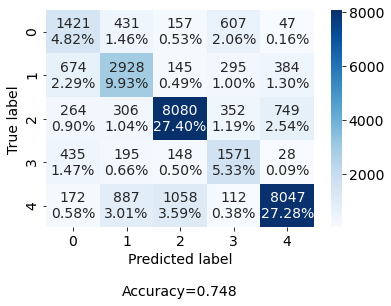

In [11]:
# display results
display_result(y_test, pred_test)

F1-score is with around 0.75 in line with our expectation from the hyperparameter search on the validation set.

In [12]:
# save predictions
np.save('./predictions/train_ft_unsup.npy', pred_train, allow_pickle=True)
np.save('./predictions/val_ft_unsup.npy', pred_val, allow_pickle=True)
np.save('./predictions/test_ft_unsup.npy', pred_test, allow_pickle=True)

## train & evaluate XGBoost classifier on top of the embeddings

In [ ]:
# XGBoost Parameters

params = {
    'objective': 'multi:softmax',
    'max_depth': 7,
    'num_class': 5,
    'eval_metric': ['merror', 'mlogloss'],
    }

num_round = 100

In [12]:
# create XGBoost datasets of the embeddings
dtrain = xgb.DMatrix(embd_train, y_train)
dval = xgb.DMatrix(embd_val, y_val)
dtest = xgb.DMatrix(embd_test, y_test)
      
evallist = [(dtrain, 'train'), (dval, 'eval')]

In [ ]:
# train classifier
xgb_clf = xgb.train(params=params,  
                    dtrain=dtrain, 
                    num_boost_round=num_round, 
                    evals=evallist,
                    early_stopping_rounds=10,
                    verbose_eval=True
                   )

# store model
dump(xgb_clf, 'models/ft_xgb.joblib') 

In [13]:
# load model (if necessary)
xgb_clf = load('./models/ft_xgb.joblib') 

In [14]:
# predictions with xgboost
pred_train = xgb_clf.predict(dtrain)
pred_val = xgb_clf.predict(dval)
pred_test = xgb_clf.predict(dtest)

f1 score micro:           0.78005
f1 score weighted:        0.77652
balanced accuracy score:  0.69351


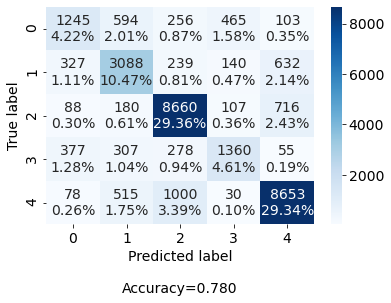

In [15]:
# display results
display_result(y_test, pred_test)

Only slight improvement of around 2-3 ppts with XGBoost over LogReg.

In [ ]:
# save predictions
np.save('./predictions/train_ft_xgb_unsup.npy', pred_train, allow_pickle=True)
np.save('./predictions/val_ft_xgb_unsup.npy', pred_val, allow_pickle=True)
np.save('./predictions/test_ft_xgb_unsup.npy', pred_test, allow_pickle=True) 

# Fasttext supervised learning

We will now apply the supervised_learning algorithm of fasttext. For details, we refer to the paper "Bag of Tricks for Efficient Text Classification" by Armand Joulin, Edouard Grave, Piotr Bojanowski and Tomas Mikolov (https://arxiv.org/pdf/1607.01759.pdf).

## Raw dataset
We first apply fasttext to the raw texts, i.e. without any further preprocessing of the sentences.

In [7]:
# Convert sentences into the required form (cf. utils.py for details)
preprocess_fasttext(mode='train', normalized=False)
preprocess_fasttext(mode='val', normalized=False, labels=False)
preprocess_fasttext(mode='test', normalized=False, labels=False)

In [3]:
# we will be working directly with the unencoded labels
_, labels_train = read_data('train')
_, labels_val = read_data('val')
_, labels_test = read_data('test')

### grid search

To reproduce results, it is recommended to uncomment the single parametrization of the model that was used in the end in order to perform only one run as grid search is otherwise very time consuming. Alternatively, the stored model can be provided upon request as it quite large (>1GB).

In [8]:
# parameters for grid search
DIMS = [100, 200]         # size of word vectors [100]
EPOCHS = [5, 10]          # number of epochs [5]
NGRAMS   = [1, 2, 5, 7]   # max length of word ngram [1]
LRS = [0.1, 1]            # learning rate [0.1]
MIN_COUNTS = [1, 5]       # minimal number of word occurences [1]
CONTEXT_WS = [5, 8]       # size of the context window [5]


# parameters for final model
# DIMS = [100]           # size of word vectors [100]
# EPOCHS = [5]           # number of epochs [5]
# NGRAMS   = [2]         # max length of word ngram [1]
# LRS = [0.1]            # learning rate [0.1]
# MIN_COUNTS = [1]       # minimal number of word occurences [1]
# CONTEXT_WS = [8]       # size of the context window [5]

In [9]:
# initialize grid search reulst file
gs_results = pd.DataFrame({ 'dim':[], 'epoch': [], 'ngram':[],
                            'lr':[], 'min_count':[], 'ws':[],
                            'f1_val':[], 'f1_test':[],
                            'bac_val':[], 'bac_test':[]
                })

models are stored in subfolder "/models"
NB: Hyperparameter search was based on F1 micro instead of weighted.

In [ ]:
# perform grid search

k = 0      # inital number of model
f1_max = 0 # starting point to track maximal f1-score on validation dataset


for dim, epoch, ngram, lr, min_count, ws in product(DIMS, EPOCHS, NGRAMS, LRS, MIN_COUNTS, CONTEXT_WS):
    print(f'Currently at model {k} with dim: {dim} - epoch: {epoch} -  ngram: {ngram} - lr: {lr} - min_count: {min_count} - context ws: {ws}')
    #model_name = 'model_ft_gs_{}'.format(k)
    # fit model
    model = fasttext.train_supervised(input = './data/fasttext_train.txt', 
                                      dim = dim, 
                                      epoch = epoch, 
                                      wordNgrams = ngram,
                                      lr = lr,
                                      minCount = min_count,
                                      ws = ws)
    
    # predict on validation & test set
    pred_val = pred_fasttext(model, mode='val')
    pred_test = pred_fasttext(model, mode='test')

    # scores
    f1_score_val = f1_score(y_val, pred_val, average='micro')
    bacc_val = balanced_accuracy_score(y_val, pred_val)
    f1_score_test = f1_score(y_test, pred_test, average='micro')
    bacc_test = balanced_accuracy_score(y_test, pred_test)
    
    # collect params and scores
    curr_res = pd.DataFrame({'dim':[dim], 'epoch': [epoch], 'ngram':[ngram],
                            'lr':[lr], 'min_count':[min_count], 'ws':[ws],
                            'f1_val':[f1_score_val], 'f1_test':[f1_score_test],
                            'bac_val':[bacc_val], 'bac_test':[bacc_test]})
   
    # combine with previous results
    gs_results = pd.concat([gs_results, curr_res], axis=0).reset_index(drop=True)
  
    # store current best model (f1 on validation)
    if f1_score_val > f1_max: 
        best_model = k
        f1_max = f1_score_val
        model.save_model('./models/model_ft_gs.bin')
    k+=1
    
print('*'*60)
print(f'Grid search finished. Best model {best_model} with f1-score val: {f1_max}.')

In [ ]:
display(gs_results.style.highlight_max(subset = ['f1_val', 'f1_test', 'bac_val', 'bac_test'], 
                                       color = 'lightgreen', axis = 0))

Model 9 had best f1-validation score:

|     | dim | epoch | ngram | lr  | min_count | ws | f1_val       | bac_val       |
|-----|-----|-------|-------|-----|-----------|----|-------------|-------------|
| 9   | 100 | 5     | 2     | 0.1 | 1         | 8  | 0.855315913  | 0.791033578  |

### load stored models for predictions

In [ ]:
# load best model according to f1 score on validation set
model = fasttext.load_model('./models/model_ft_gs.bin')

# predict on test set
pred_train = pred_fasttext(model, mode='train')
pred_val = pred_fasttext(model, mode='val')
pred_test = pred_fasttext(model, mode='test')

f1 score micro:           0.85495
f1 score weighted:        0.85382
balanced accuracy score:  0.79086


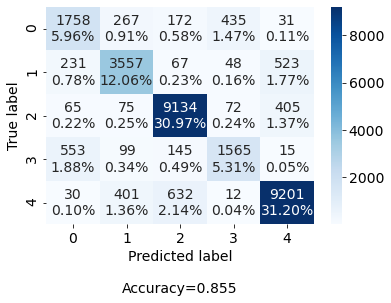

In [18]:
# display results
display_result(labels_test, pred_test)

The supervised method and its bag of tricks, decreases not only training time in comparison to the unsupervised method, but also lifts the F1-score by around 10 ppts.

In [14]:
# save predictions
np.save('./predictions/train_ft_sup.npy', pred_train, allow_pickle=True)
np.save('./predictions/val_ft_sup.npy', pred_val, allow_pickle=True)
np.save('./predictions/test_ft_sup.npy', pred_test, allow_pickle=True)

## Preprocessed  dataset
In the following, we will check whether preprocessing and thus the decrease in vocabulary has a positive effect for the supervised method as was observed for the unsupervised one (note that the results for the unpreprocessed unsupervised variant are not presented above)

- Clean end-of-line characters
- Lowercase
- Tokenize
- Stopwords removal
- Digit replacement

In [7]:
# create preprocessed text files for input to fasttext
preprocess_fasttext(mode='train', normalized=True)
preprocess_fasttext(mode='val', normalized=True, labels=False)
preprocess_fasttext(mode='test', normalized=True, labels=False)

### grid search

To reproduce results, it is recommended to uncomment the single parametrization of the model that was used in the end in order to perform only one run as grid search is otherwise very time consuming. Alternatively, the stored model can be provided upon request as it quite large (>1GB).

In [9]:
# parameters for grid search
DIMS = [100, 200]        # size of word vectors [100]
EPOCHS = [5, 10]         # number of epochs [5]
NGRAMS   = [1, 2, 5, 7]  # max length of word ngram [1]
LRS = [0.01, 0.1]        # learning rate [0.1]
MIN_COUNTS = [1, 5]      # minimal number of word occurences [1]
CONTEXT_WS = [5, 8]      # size of the context window [5]

# parameters for final model
# DIMS = [200]          # size of word vectors [100]
# EPOCHS = [10]         # number of epochs [5]
# NGRAMS   = [2]        # max length of word ngram [1]
# LRS = [0.01]          # learning rate [0.1]
# MIN_COUNTS = [1]      # minimal number of word occurences [1]
# CONTEXT_WS = [5]      # size of the context window [5]

In [8]:
# initiliaze grid search result file
gs_preproc_results = pd.DataFrame({ 'dim':[], 'epoch': [], 'ngram':[],
                            'lr':[], 'min_count':[], 'ws':[],
                            'f1_val':[], 'f1_test':[],
                            'bac_val':[], 'bac_test':[]
                })

In [ ]:
# perform grid search

k = 0      # inital number of model
f1_max = 0 # starting point to track maximal f1-score on validation dataset


for dim, epoch, ngram, lr, min_count, ws in product(DIMS, EPOCHS, NGRAMS, LRS, MIN_COUNTS, CONTEXT_WS):
    print(f'Currently at model {k} with dim: {dim} - epoch: {epoch} -  ngram: {ngram} - lr: {lr} - min_count: {min_count} - context ws: {ws}')
    #model_name = 'model_ft_gs_{}'.format(k)
    # fit model
    model = fasttext.train_supervised(input = './data/fasttext_norm_train.txt', 
                                      dim = dim, 
                                      epoch = epoch, 
                                      wordNgrams = ngram,
                                      lr = lr,
                                      minCount = min_count,
                                      ws = ws)
    # predict on validation & test set
    pred_val = pred_fasttext(model, normalized=True, mode='val')
    pred_test = pred_fasttext(model, normalized=True, mode='test')

    # scores
    f1_score_val = f1_score(y_val, pred_val, average='micro')
    bacc_val = balanced_accuracy_score(y_val, pred_val)
    f1_score_test = f1_score(y_test, pred_test, average='micro')
    bacc_test = balanced_accuracy_score(y_test, pred_test)
    
    # collect params and scores
    curr_res = pd.DataFrame({'dim':[dim], 'epoch': [epoch], 'ngram':[ngram],
                            'lr':[lr], 'min_count':[min_count], 'ws':[ws],
                            'f1_val':[f1_score_val], 'f1_test':[f1_score_test],
                            'bac_val':[bacc_val], 'bac_test':[bacc_test]})
   
    # combine with previous results
    gs_preproc_results = pd.concat([gs_preproc_results, curr_res], axis=0).reset_index(drop=True)
  
    # store current best model (f1 on validation)
    if f1_score_val > f1_max: 
        best_model = k
        f1_max = f1_score_val
        model.save_model('./models/model_ft_gs_preproc.bin')
    k+=1
    
print('*'*60)
print(f'Grid search finished. Best model {best_model} with f1-score val: {f1_max}.')

In [ ]:
display(gs_preproc_results.style.highlight_max(subset = ['f1_val', 'f1_test', 'bac_val', 'bac_test'], 
                                       color = 'lightgreen', axis = 0))

With preprocessed dataset, model 104 had the best f1-validation score, albeit a lower one than without any additional preprocessing (see model 9 above with f1-score of 0.855315913)

|     | dim | epoch | ngram | lr  | min_count | ws | f1_val      | bac_val     |
|-----|-----|-------|-------|-----|-----------|----|-------------|-------------|
|104|200|10|2|0.01|1|5|0.824001|0.752971|

### load stored models for predictions

In [ ]:
# load best model according to f1 score on validation set
model = fasttext.load_model('./models/model_ft_gs_preproc.bin')

# predict on test set
pred_train = pred_fasttext(model, normalized=True, mode='train')
pred_val = pred_fasttext(model, normalized=True, mode='val')
pred_test = pred_fasttext(model, normalized=True, mode='test')

f1 score micro:           0.82331
f1 score weighted:        0.82159
balanced accuracy score:  0.75189


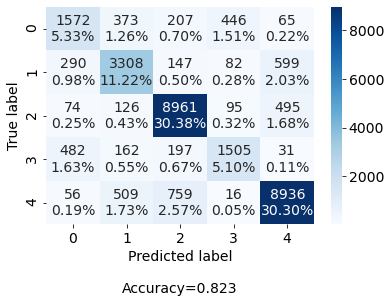

In [5]:
# display results
display_result(labels_test, pred_test)

We note that preprocessing has a detrimental effect for the supervised version. Concretely, f1-score decreases by approx. 3 ppts.

In [16]:
# save predictions
np.save('./predictions/train_ft_sup_preproc.npy', pred_train, allow_pickle=True)
np.save('./predictions/val_ft_sup_preproc.npy', pred_val, allow_pickle=True)
np.save('./predictions/test_ft_sup_preproc.npy', pred_test, allow_pickle=True)

# END